# LIBRARIES


In [1]:
import os
import keras
import numpy as np
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from random import random
! pip install tensorflow_addons
# Data
import tensorflow.image as tfi
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

# Model Layers
from keras.layers import ReLU
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import concatenate
from keras.layers import ZeroPadding2D
from keras.layers import Conv2DTranspose
from tensorflow_addons.layers import InstanceNormalization

# Model Functions
from keras.models import Model
from keras.models import load_model
from keras.models import Sequential
from keras.initializers import RandomNormal

# Optimizers
from tensorflow.keras.optimizers import Adam

# Loss
from keras.losses import BinaryCrossentropy

# Model Viz
from tensorflow.keras.utils import plot_model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 14.2 MB/s 


# DATA PREPARATION

In [2]:
def show_image(image, title=None):
    '''
    The function takes in an image and plots it using Matplotlib.
    '''
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

In [3]:
from google.colab import drive
drive.mount('MyDrive')


Mounted at MyDrive


In [4]:
root_horse_path = ('MyDrive/MyDrive/Colab Notebooks/GAN TESTING/TRAIN A')
root_zebra_path = ('MyDrive/MyDrive/Colab Notebooks/GAN TESTING/TRAIN B')
horse_paths = sorted(glob(root_horse_path + '/*.jpg'))[:1000]
zebra_paths = sorted(glob(root_zebra_path + '/*.jpg'))[:1000]

In [5]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]
    return img

In [6]:
SIZE = 256
horse_images, zebra_images = np.zeros(shape=(len(horse_paths),SIZE,SIZE,3)), np.zeros(shape=(len(horse_paths),SIZE,SIZE,3))
for i,(horse_path, zebra_path) in tqdm(enumerate(zip(horse_paths, zebra_paths)), desc='Loading'):
    
    horse_image = img_to_array(load_img(horse_path))
    horse_image = tfi.resize(tf.cast(horse_image, tf.float32)/255., (SIZE, SIZE))
    
    zebra_image = img_to_array(load_img(zebra_path))
    zebra_image = tfi.resize(tf.cast(zebra_image,tf.float32)/255., (SIZE, SIZE))
    
    # as the data is unpaired so we don't have to worry about, positioning the images.
    
    horse_images[i] = horse_image
    zebra_images[i] = zebra_image

Loading: 1000it [08:23,  1.99it/s]


# DATA CHECKING

In [7]:
dataset = [horse_images, zebra_images]

In [8]:
len(horse_images)

1000

# RESIDUAL BLOCK / UPSAMPLE / DOWNSAMPLE

In [9]:
def ResidualBlock(filters, layer, index):
#     init = RandomNormal(stddev=0.02)
    
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False, name="Block_{}_Conv1".format(index))(layer)
    x = InstanceNormalization(axis=-1, name="Block_{}_Normalization1".format(index))(x)
    x = ReLU(name="Block_{}_ReLU".format(index))(x)
    
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False, name="Block_{}_Conv2".format(index))(x)
    x = InstanceNormalization(axis=-1, name="Block_{}_Normalization2".format(index))(x)
    
    x = concatenate([x, layer], name="Block_{}_Merge".format(index))
    
    return x

In [10]:
def downsample(filters, layer, size=3, strides=2, activation=None, index=None, norm=True):
    x = Conv2D(filters, kernel_size=size, strides=strides, padding='same', kernel_initializer='he_normal', use_bias=False, name="Encoder_{}_Conv".format(index))(layer)
    if norm:
        x = InstanceNormalization(axis=-1, name="Encoder_{}_Normalization".format(index))(x)
    if activation is not None:
        x = Activation(activation, name="Encoder_{}_Activation".format(index))(x)
    else:
        x = LeakyReLU( name="Encoder_{}_LeakyReLU".format(index))(x)
    return x

In [11]:
def upsample(filters, layer, size=3, strides=2, index=None):
    x = Conv2DTranspose(filters, kernel_size=size, strides=strides, padding='same', kernel_initializer='he_normal', use_bias=False, name="Decoder_{}_ConvT".format(index))(layer)
    x = InstanceNormalization(axis=-1, name="Decoder_{}_Normalization".format(index))(x)
    x = ReLU( name="Encoder_{}_ReLU".format(index))(x)
    return x

# GENERATOR AND DISCRIMINATOR FUNCTION

In [12]:
def Generator(n_resnet=9, name="Generator"):
    
    inp_image = Input(shape=(SIZE, SIZE, 3), name="InputImage")         # 256 x 256 x3
    
    x = downsample(64, inp_image, size=7, strides=1, index=1)           # 256 x 256 x 64
    x = downsample(128, x, index=2)                                     # 128 x 128 x 128
    x = downsample(256, x, index=3)                                     # 64 x 64 x 256
    
    for i in range(n_resnet):
        x = ResidualBlock(256, x, index=i+4)                             # (64 x 64 x 256) x n_resnet
    
    x = upsample(128, x, index=13)                                       # 128 x 128 x 128
    x = upsample(64, x, index=14)                                        # 256 x 256 x 64
    x = downsample(3, x, size=7, strides=1, activation='tanh', index=15) # 256 x 256 x 3
    
    model = Model(
        inputs=inp_image,
        outputs=x,
        name=name
    )
    return model

In [13]:
def Discriminator(name='Discriminator'):
    init = RandomNormal(stddev=0.02)
    src_img = Input(shape=(SIZE, SIZE, 3), name="InputImage")     # 256 x 256 x 3
    x = downsample(64, src_img, size=4, strides=2, index=1, norm=False) # 128 x 128 x 64
    x = downsample(128, x, size=4, strides=2, index=2)            # 64 x 64 x 128
    x = downsample(256, x, size=4, strides=2, index=3)            # 32 x 32 x 256
    x = downsample(512, x, size=4, strides=2, index=4)            # 16 x 16 x 512
    x = downsample(512, x, size=4, strides=2, index=5)            # 8 x 8 x 512  # we can try out a different architecture with zero padding layer.
    patch_out = Conv2D(1, kernel_size=4, padding='same', kernel_initializer=init, use_bias=False)(x) # 8 x 8 x 1
    
    model = Model(
        inputs=src_img,
        outputs=patch_out,
        name=name
    )
    model.compile(
        loss='mse',
        optimizer=Adam(learning_rate=2e-4, beta_1=0.5),
        loss_weights=[0.5]
    )
    return model

# COMBINE MODEL

In [14]:
def CombineModel(g_model1, g_model2, d_model, name):
    # train the Generator
    g_model1.trainable = True

    # Stop the Discriminator and 2nd Generator
    d_model.trainable = False
    g_model2.trainable = False
    
    # Adversarial Loss
    input_gen = Input(shape=(SIZE, SIZE, 3))
    gen_1_out = g_model1(input_gen)
    dis_out = d_model(gen_1_out)
    
    # Identity Loss
    input_id = Input(shape=(SIZE, SIZE, 3))
    output_id = g_model1(input_id)
    
    # Cycle Loss - Forward
    output_f = g_model2(gen_1_out)
    
    # Cycle Loss - Backward
    gen_2_out = g_model2(input_id)
    output_b = g_model1(gen_2_out)
    
    # Final Model 
    model = Model(
        inputs=[input_gen, input_id],
        outputs=[dis_out, output_id, output_f, output_b],
        name=name
    )
    model.compile(
        loss=['mse', 'mae', 'mae', 'mae'],
        loss_weights=[1,5,10,10],
        optimizer= Adam(learning_rate=2e-4, beta_1=0.5)
    )
    return model

# GENERATE REAL AND FAKE SAMPLES

In [15]:
def generate_real_samples(n_samples, dataset):
    ix = np.random.randint(0,dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones(shape=(n_samples, 8, 8, 1))
    return X, y

In [16]:
def generate_fake_samples(g_model, dataset):
    X = g_model.predict(dataset)
    y = np.zeros(shape=(len(dataset), 8, 8, 1))
    return X, y

In [17]:
def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            selected.append(image)
        else:
            ix = np.random.randint(0,len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return np.asarray(selected)

# SHOW PREDICTION AND TRAINING FUNCTION

In [18]:
def show_preds(g_AB, g_BA,n_images=1):
    for i in range(n_images):
        
        id = np.random.randint(len(horse_images))
        horse, zebra = horse_images[id], zebra_images[id]
        horse_pred, zebra_pred = g_BA.predict(tf.expand_dims(zebra,axis=0))[0], g_AB.predict(tf.expand_dims(horse,axis=0))[0]
        
        plt.figure(figsize=(10,8))
        
        plt.subplot(1,4,1)
        show_image(horse, title='Original Horse')
        
        plt.subplot(1,4,2)
        show_image(zebra_pred, title='Generated Zebra')
        
        plt.subplot(1,4,3)
        show_image(zebra, title='Original Zebra')
        
        plt.subplot(1,4,4)
        show_image(horse_pred, title='Genrated Horse')
        
        plt.tight_layout()
        plt.show()

In [19]:
def train(d_model_A, d_model_B, gen_AB, gen_BA, c_AB, c_BA, epochs=10, chunk=5):
    
    n_epochs, n_batch = epochs, 1
    
    trainA, trainB = dataset
    poolA, poolB = list(), list()
    
    # in simple words, we are going through the whole data.
    bat_per_epoch = int(len(trainA)/n_batch)
    n_steps = bat_per_epoch
    
    for j in tqdm(range(1,epochs+1), desc="Epochs"):
        for i in range(n_steps):
            
            # Let's get some real data in hand.
            X_realA, y_realA = generate_real_samples(n_batch, trainA)
            X_realB, y_realB = generate_real_samples(n_batch, trainB)

            # use our generators to generate some fake data.
            X_fakeA, y_fakeA = generate_fake_samples(gen_BA, X_realB)
            X_fakeB, y_fakeB = generate_fake_samples(gen_AB, X_realA)
            
            # create a pool of images. You can also understand it like a replay buffer.
            X_fakeA = update_image_pool(poolA, X_fakeA)
            X_fakeB = update_image_pool(poolA, X_fakeB)
            
            
            # Let's finally train the gen 2 and get the losses.
            gen_loss2, _, _, _, _ = c_BA.train_on_batch(
                [X_realB, X_realA],
                [y_realB, X_realA, X_realB, X_realA]
            )
            
            # It's time for our discriminator to win our generator.
            dA_loss_1 = d_model_A.train_on_batch(X_realA, y_realA)
            dA_loss_2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
            
            # one cycle is completed, let's move to second cycle.
            gen_loss1, _, _, _, _ = c_AB.train_on_batch(
                [X_realA, X_realB],
                [y_realA, X_realB, X_realA, X_realB]
            )
            
            # again, let's give some power to our discriminators.
            dB_loss_1 = d_model_B.train_on_batch(X_realB, y_realB)
            dB_loss_2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)

        if (j%chunk)==0:
            show_preds(gen_AB, gen_BA, n_images=1)
            gen_AB.save("GeneratorHtoZ.h5")
            gen_BA.save("GeneratorZtoH.h5")

# GENERATOR AND TRAINING 

In [20]:
# let's create our generators.
g_AB = Generator(name="GeneratorAB")
g_BA = Generator(name="GeneratorBA")

# here are the respective discriminators.
d_A = Discriminator(name="DiscriminatorA")
d_B = Discriminator(name="DiscriminatorB")

# finally, let's combine all of them.
c_AB = CombineModel(g_AB, g_BA, d_B, name="GanAB")
c_BA = CombineModel(g_BA, g_AB, d_A, name="GanBA")

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epochs:  10%|█         | 1/10 [37:23<5:36:28, 2243.19s/it]

1/1 [==============================] - 0s 24ms/step


Epochs:  20%|██        | 2/10 [1:13:48<4:54:32, 2209.06s/it]

1/1 [==============================] - 0s 21ms/step


Epochs:  30%|███       | 3/10 [1:50:19<4:16:45, 2200.78s/it]

1/1 [==============================] - 0s 21ms/step


Epochs:  40%|████      | 4/10 [2:26:47<3:39:35, 2195.84s/it]

1/1 [==============================] - 1s 879ms/step


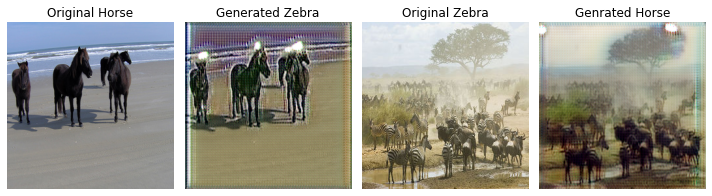

Epochs:  50%|█████     | 5/10 [3:03:18<3:02:50, 2194.20s/it]

1/1 [==============================] - 0s 22ms/step


Epochs:  60%|██████    | 6/10 [3:39:53<2:26:17, 2194.47s/it]

1/1 [==============================] - 0s 20ms/step


Epochs:  70%|███████   | 7/10 [4:16:35<1:49:50, 2196.89s/it]

1/1 [==============================] - 0s 21ms/step


Epochs:  80%|████████  | 8/10 [4:53:18<1:13:17, 2198.70s/it]

1/1 [==============================] - 0s 23ms/step


Epochs:  90%|█████████ | 9/10 [5:30:04<36:41, 2201.14s/it]  

1/1 [==============================] - 0s 22ms/step


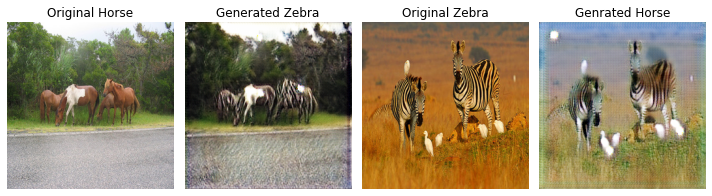

Epochs: 100%|██████████| 10/10 [6:06:55<00:00, 2201.58s/it]


In [21]:
# # it's time to give them the superior knowledge.
train(d_A, d_B, g_AB, g_BA, c_AB, c_BA, epochs=10, chunk=5)

# SAVING AND LOADING THE MODEL

In [25]:
g_AB.save("HorseToZebra.h5")
g_BA.save("ZebraToHorse.h5")

In [28]:
Horse_Zebra = load_model("HorseToZebra.h5")
Zebra_Horse = load_model("ZebraToHorse.h5")

# MODEL PREDICTIONS

1/1 [==============================] - 0s 51ms/step


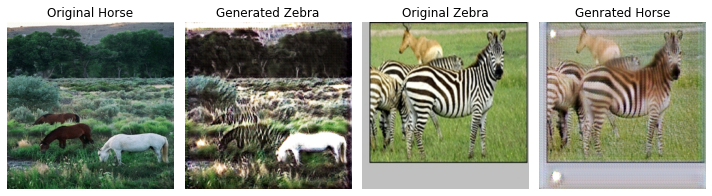

1/1 [==============================] - 0s 22ms/step


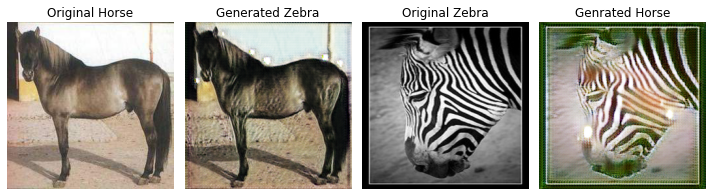

1/1 [==============================] - 0s 24ms/step


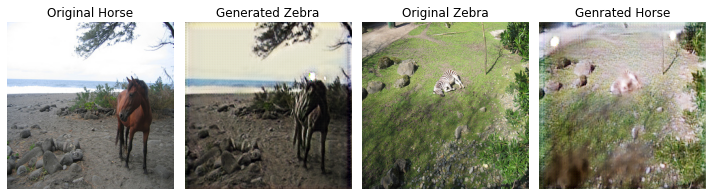

1/1 [==============================] - 0s 22ms/step


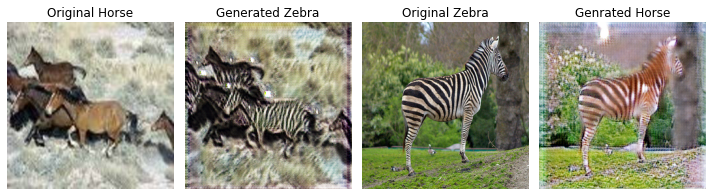

1/1 [==============================] - 0s 21ms/step


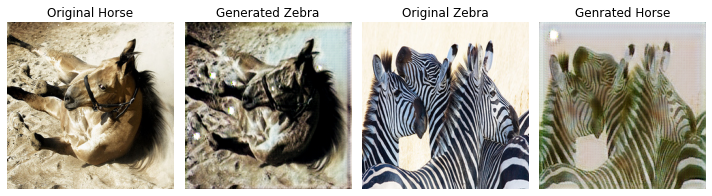

1/1 [==============================] - 0s 24ms/step


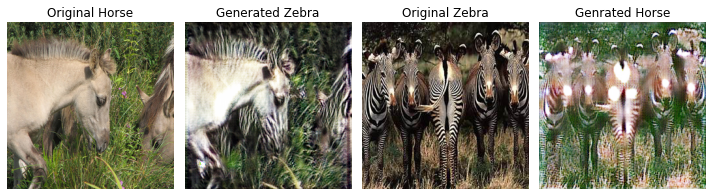

1/1 [==============================] - 0s 24ms/step


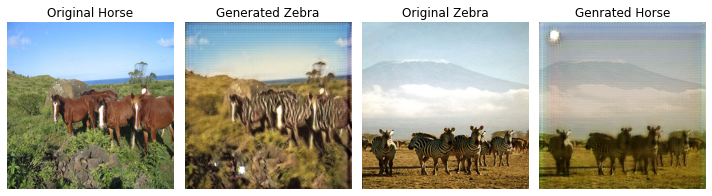

1/1 [==============================] - 0s 22ms/step


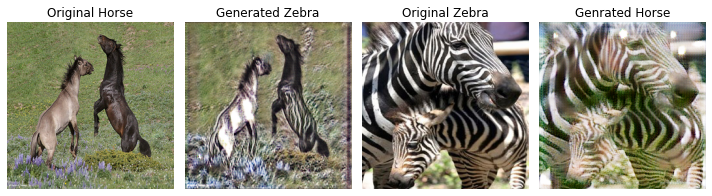

1/1 [==============================] - 0s 32ms/step


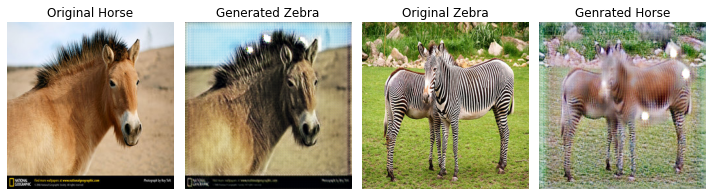

1/1 [==============================] - 0s 22ms/step


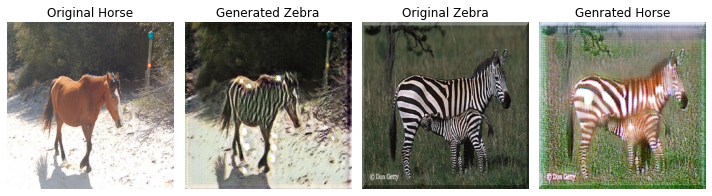

In [30]:
show_preds(Horse_Zebra, Zebra_Horse, n_images=10)